# Atlas Code

We can use the integrated dataset to explore expression of pathway genes across different timepoints in the mouse lifespan.

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
import itertools

# For natural sorting of gene names
from natsort import natsorted

# For normalization of gene counts
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Data directory
datadir = "./data/"

In [3]:
# Import necessary files
# Load the atlas dataset of counts
counts = pd.read_csv(datadir + "counts.csv", index_col = [0]).T

# Import csvs with metadata
meta = pd.read_csv(datadir + "meta.csv", index_col = [0])
pathways = pd.read_csv(datadir + "pathway_list.csv")

In [4]:
# Normalize the data such that the total counts per cluster is 1e4, then take the log
integrated_counts = np.log1p(counts.div(counts.sum(axis=1),axis=0)*1e4)

# A quick check
np.expm1(integrated_counts).sum(axis = 1)

1_E6.5_8.5_Chan    10000.0
2_E6.5_8.5_Chan    10000.0
3_E6.5_8.5_Chan    10000.0
4_E6.5_8.5_Chan    10000.0
5_E6.5_8.5_Chan    10000.0
                    ...   
1202_FACS 3m       10000.0
1203_FACS 3m       10000.0
1204_FACS 3m       10000.0
1205_FACS 3m       10000.0
1206_FACS 3m       10000.0
Length: 1206, dtype: float64

## Scaling of Counts

Since RNA count distributions skewed right, we can more robustly saturate count values by scaling the maximum to be the 99th percentile of expression for a given gene. 

The function below saturates the expression values in a DataFrame at inputted gene-specific percentiles.

In [5]:
# Returns a clipped matrix given a list of max values (values to clip at) for each gene
def quantile_saturation(x = [], gene_quantiles = []):
    
    col_order = list(x.columns)
    
    x_clipped = pd.DataFrame()
    # Saturate the values based on 99% quantile (more robust than using the abs max)
    for i in x.index:
        x_clipped =  x_clipped.append(np.clip(x.loc[i], a_min=0, a_max = gene_quantiles))
        
    # Pandas automatically makes the new df columns alphabetically ordered
    # re-order columns how they were originally entered by the user
    
    x_clipped = x_clipped[col_order]
    
    return x_clipped

In [6]:
# Compute the 99th quantile per gene
gene_quantiles = np.quantile(integrated_counts, q = 0.99, axis = 0)

# Clip the values such that any counts above the 99th quantile take its value
x_clipped = quantile_saturation(integrated_counts, gene_quantiles)
x_clipped.describe() 

,Abi2,Acadl,Actr1b,Adam23,Adhfe1,Aff3,Als2,Ankrd39,Ankrd44,Arfgef1,...,Vldlr,Vps13a,Vti1a,Vwa2,Xpnpep1,Zdhhc16,Zdhhc6,Zfand5,Zfp518a,Zfyve27
count,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,...,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000
mean,0.131104,0.419033,0.299646,0.034659,0.041421,0.059043,0.022537,0.088134,0.147925,0.243440,...,0.064797,0.108834,0.075243,0.009736,0.329053,0.201650,0.273688,0.792094,0.079371,0.099893
std,0.120448,0.316629,0.191796,0.125192,0.149613,0.083150,0.021302,0.055952,0.163787,0.192053,...,0.130461,0.092880,0.044354,0.024580,0.204267,0.135871,0.166604,0.424579,0.058900,0.074068
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006666,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027770,0.000000,0.000000
25%,0.032132,0.196822,0.136698,0.000000,0.000000,0.004852,0.009038,0.046637,0.013629,0.111159,...,0.000835,0.038561,0.044204,0.000000,0.164449,0.082440,0.127221,0.529310,0.038978,0.052322
50%,0.094997,0.334985,0.256611,0.003012,0.002350,0.024880,0.017346,0.084176,0.079003,0.202464,...,0.015677,0.083446,0.066156,0.000000,0.287315,0.187149,0.266036,0.677916,0.068851,0.079929
75%,0.205766,0.532262,0.454596,0.015538,0.011664,0.076560,0.028825,0.116672,0.249609,0.301298,...,0.053449,0.149860,0.097640,0.006300,0.479835,0.316328,0.405449,0.941316,0.106118,0.121980
max,0.522994,1.575520,0.746896,0.967272,1.035661,0.412882,0.123911,0.279431,0.692043,0.961763,...,0.694113,0.460004,0.214049,0.139733,0.901013,0.510094,0.652144,2.139223,0.338800,0.429825


We can now scale expression values in this DataFrame of "clipped" counts to lie between 0 and 1, using a simple MinMaxScaler from scikitlearn that linearly scales counts to lie between the minimum and maximum expression value per gene.

In [7]:
# Initialize the scaler
scaler = MinMaxScaler()
# Fit the scaler to the dataset to compute per-feature min. and max. values
scaler.fit(x_clipped)

# Apply the scaler to the dataset
df_scale = pd.DataFrame(scaler.transform(x_clipped), columns = x_clipped.columns, index = x_clipped.index)

# Add annotations to our dataframe
df_scale['cell_id'] = meta['cell_id']
df_scale['Cell_class'] = meta['Cell_class']

df_scale.head()

,Abi2,Acadl,Actr1b,Adam23,Adhfe1,Aff3,Als2,Ankrd39,Ankrd44,Arfgef1,...,Vti1a,Vwa2,Xpnpep1,Zdhhc16,Zdhhc6,Zfand5,Zfp518a,Zfyve27,cell_id,Cell_class
1_E6.5_8.5_Chan,0.580457,0.140350,0.676575,0.028686,0.004046,0.151459,0.426125,0.431623,0.012108,0.154960,...,0.243324,0.129005,0.492912,0.619371,0.767157,0.246361,0.651432,0.146973,1_E6.5_8.5_Chan,Epiblast
2_E6.5_8.5_Chan,0.241409,0.092006,0.508189,0.017349,0.011275,0.080465,0.048021,0.494967,0.000000,0.071724,...,0.152335,0.030652,0.425883,0.424370,0.530597,0.252955,0.253046,0.056076,2_E6.5_8.5_Chan,Ectoderm
3_E6.5_8.5_Chan,0.458171,0.113981,0.654406,0.068303,0.005145,0.162122,0.372052,0.547446,0.020579,0.194061,...,0.218735,0.264121,0.333217,0.533762,0.755081,0.254879,0.843063,0.154786,3_E6.5_8.5_Chan,Epiblast
4_E6.5_8.5_Chan,0.546443,0.144844,0.677988,0.058156,0.004190,0.167652,0.400421,0.677206,0.017567,0.184765,...,0.162087,0.157618,0.464262,0.600279,0.768458,0.286603,0.565512,0.125318,4_E6.5_8.5_Chan,Epiblast
5_E6.5_8.5_Chan,0.118424,0.124991,0.787027,0.002007,0.001205,0.021202,0.310272,0.562648,0.001915,0.242430,...,0.413131,0.009482,0.756758,0.608769,0.765071,0.234795,0.345693,0.140809,5_E6.5_8.5_Chan,Ex_ectoderm


## Example Pathway

We have scaled counts such that expression values for each gene in our atlas lies between 0 and 1. We can now look at expression of genes in specific pathways of interest and evaluate how these vary across different timepoints, cell types, etc. 

I'll demonstrate some possible queries we can make using the Notch signaling pathway. We can subset the scaled counts of the Notch genes and proceed.

We can substitute this pathway with any other pathways or subsets of genes. The DataFrame "pathways" contains curated lists of genes in select pathways (as shown below). 

In [8]:
# The pathways that are in our curated list
# l means ligands, r means receptors
pathways["pathway"].unique()

array(['Bmp_l', 'Notch', 'Bmp_Tgfb', 'Bmp', 'Wnt', 'Eph_r', 'Eph_l',
       'Fgfr', 'Srsf', 'Lpa', 'Wnt_l', 'Bmp_down', 'Bmp_fun'],
      dtype=object)

I will use the list of Notch components stored in our curated list above. Otherwise, if you want to study a set of signaling genes not stored in this object, simply change the pathway name and list of genes below.

In [9]:
# Select the Notch genes from our reference list
pathway = "Notch"
genes = list(pathways[pathways["pathway"] == pathway]["gene"].values)

As of now, the integrated atlas only consists of the intersection of genes that are expressed at a basal level in all datasets (for a total of 11,675 genes out of ~22k total). Some genes specified in our list above may not be contained within this intersection, so we filter them out below, and subset the remaining pathway genes.

In [10]:
# Subset a DataFrame with only the genes selected above
pathway_genes = [i for i in genes if i in df_scale.columns]

df_pathway = df_scale[pathway_genes]

df_pathway.head()

,Dll1,Dll3,Dll4,Jag1,Jag2,Notch1,Notch2,Notch3,Notch4,Mfng,Rfng,Lfng
1_E6.5_8.5_Chan,0.014819,0.136275,0.000000,0.041043,0.016864,0.046589,0.062934,0.064582,0.114331,0.026468,0.236436,0.015711
2_E6.5_8.5_Chan,0.000000,0.068862,0.000000,0.005510,0.000000,0.001764,0.009885,0.008756,0.071154,0.034318,0.182304,0.000000
3_E6.5_8.5_Chan,0.010974,0.073606,0.000000,0.040344,0.000000,0.036166,0.429603,0.062882,0.062029,0.063305,0.188277,0.025875
4_E6.5_8.5_Chan,0.006131,0.088485,0.002994,0.008539,0.007506,0.032810,0.032471,0.059412,0.101778,0.073151,0.238092,0.027696
5_E6.5_8.5_Chan,0.001608,0.057720,0.000000,0.001342,0.033267,0.015496,0.037971,0.001749,0.160801,0.007979,0.429918,0.001190


### Pathway gene expression

To visualize pathway activation, we can visualize the number of clusters in which pathway components are turned "ON."

In [11]:
# Select a threshold for expression being "ON"
thresh = 0.1

In [12]:
# Count number of clusters that have expression above the threshold for "ON"
df_thresh = pd.DataFrame((df_pathway >= thresh).apply(np.count_nonzero), columns = ["counts"])

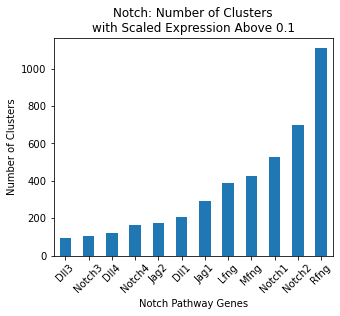

In [13]:
fig, ax = plt.subplots(figsize = (5,4))
df_thresh.sort_values(by = ["counts"]).plot.bar(ax = ax)
ax.set_title(pathway + ": Number of Clusters\nwith Scaled Expression Above "+ str(thresh))
ax.set_xlabel(pathway + " Pathway Genes")
ax.tick_params(axis='x', rotation=45)

ax.set_ylabel("Number of Clusters")
ax.get_legend().remove()

### Cell Type Expression of Pathway Genes

Similarly, we can visualize the distribution of pathway expression across different tissues. 

In [14]:
# Obtain counts >= 0.1
df_ct_thresh = df_pathway[df_pathway >= 0.1]

# Add Cell type annotations from metadata file
df_ct_thresh["Cell_class"] = meta["Cell_class"]

# Group by cell type to count the number of clusters with expression of pathway components
df_ct_thresh = df_ct_thresh.groupby("Cell_class").count().div(meta.groupby("Cell_class")["Cell_class"].count(), axis='rows')

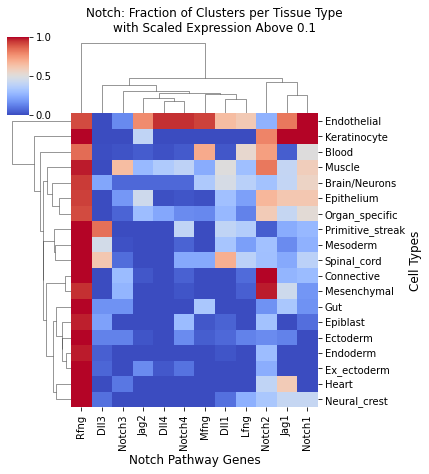

In [15]:
g = sns.clustermap(df_ct_thresh, cmap = "coolwarm", figsize = (6,6),
                   # Choosing to keep euclidean clustering of genes and tissue types
                   row_cluster = True, col_cluster = True);

# Set title
g.fig.suptitle(pathway + ": Fraction of Clusters per Tissue Type\nwith Scaled Expression Above "+ str(thresh),
              y = 1.05)

# Set axes labels
g.ax_heatmap.set_xlabel(pathway + " Pathway Genes", fontsize = 12)
g.ax_heatmap.set_ylabel("Cell Types", fontsize = 12);

### Co-Expression Heatmap

We can quantify co-expression by counting the number of clusters that express pairs of Notch components above the specified threshold, which is visualized below as a heatmap.

In [16]:
# Construct a square matrix to quantify co-expression
arrays = [
    np.repeat(pathway_genes, len(pathway_genes)),
    np.array(pathway_genes*len(pathway_genes))
]

coexp_df = pd.DataFrame(columns = arrays)

for i in pathway_genes:
    for j in pathway_genes:
        coexp_df[(i, j)] = np.where((df_pathway[i] >= 0.1) & (df_pathway[j] >= 0.1), 1, 0)
    
coexp_df = coexp_df.sum(axis = 0).unstack(level = 0)

The block of code below is specific to Notch—for a neater display, I simply want to make sure that the different component types are grouped together in our plot, and so I specify the order below.

In [17]:
# Specify the order of genes we want to display in our heatmap 
# (seprating ligands from receptors, etc.)
genes_order = ['Dll1', 'Dll3', 'Dll4', # Delta ligands
               'Jag1', 'Jag2', # Jag ligands
               'Notch1', 'Notch2', 'Notch3', 'Notch4', # Notch receptors
               'Lfng', 'Mfng', 'Rfng'] # Fringes

coexp_df = coexp_df.loc[genes_order][genes_order]

coexp_df

,Dll1,Dll3,Dll4,Jag1,Jag2,Notch1,Notch2,Notch3,Notch4,Lfng,Mfng,Rfng
Dll1,207,47,75,119,95,151,93,24,78,114,84,202
Dll3,47,93,1,17,1,35,15,2,21,28,8,93
Dll4,75,1,120,90,88,111,38,23,102,61,94,111
Jag1,119,17,90,294,136,219,198,68,93,99,94,285
Jag2,95,1,88,136,172,152,89,29,89,78,90,164
Notch1,151,35,111,219,152,527,349,65,117,251,261,484
Notch2,93,15,38,198,89,349,699,91,55,260,275,631
Notch3,24,2,23,68,29,65,91,106,29,29,26,104
Notch4,78,21,102,93,89,117,55,29,163,78,105,154
Lfng,114,28,61,99,78,251,260,29,78,388,281,375


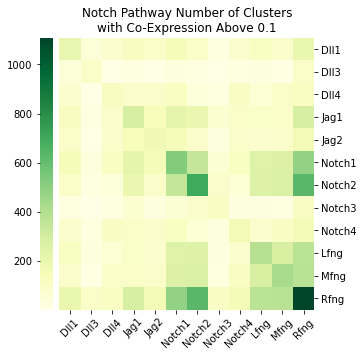

In [18]:
fig,ax = plt.subplots(figsize = (5.5,5))

#Heatmap
sns.heatmap(coexp_df, cmap = "YlGn", ax = ax, 
            cbar_kws = dict(use_gridspec=False, location="left", pad=0.02))

# Rotate x labels
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45);

# Shift y labels to the right
ax.yaxis.tick_right()
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0);

# Set title
ax.set_title(pathway + " Pathway Number of Clusters\nwith Co-Expression Above " + str(thresh));